## 特征选择
当数据特征维度过大，则在传统机器学习中需要选择有效的特征进行训练，主要介绍特征选择的方式方法
### 过滤法

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('./digit recognizor.csv')
X = data.iloc[:,1:]
y = data.iloc[:,0]
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X['pixel200'].value_counts()

0      41151
253       53
254       38
255       16
5         15
252       13
7         13
128       12
3         10
1         10
32         9
64         9
2          8
4          8
14         8
22         8
28         8
47         8
86         7
13         7
203        7
9          7
101        7
24         7
8          7
55         7
80         7
25         7
51         7
57         6
       ...  
187        1
78         1
213        1
75         1
42         1
246        1
181        1
235        1
119        1
180        1
116        1
140        1
120        1
152        1
184        1
216        1
89         1
135        1
52         1
217        1
166        1
243        1
211        1
173        1
186        1
205        1
147        1
170        1
59         1
176        1
Name: pixel200, Length: 219, dtype: int64

In [5]:
df.shape

(42000, 785)

如果某些特征的方差很小。则说明该特征基本没有差异，则对于目标的变化影响也较小，因此可以先用方差进行过滤，将特征差异小的值删除。

In [5]:
#方差过滤
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
x_var0 = selector.fit_transform(X)
x_var0.shape

(42000, 708)

In [7]:
#删除一半的方差值
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)
X.var().values
np.median(X.var().values)
X_fsvar.shape

(42000, 392)

In [8]:
#对于随机森林模型的方差过滤前后表现
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print(cross_val_score(RandomForestClassifier(random_state=0,n_estimators=10),X,y,cv=5).mean())
print(cross_val_score(RandomForestClassifier(random_state=0,n_estimators=10),X_fsvar,y,cv=5).mean())

0.9380003861799541
0.9388098166696807


#### 讨论：方差过滤对于随机森林和knn的影响分析以及随机森林和决策树在维度选择中的表现分析

### 相关性过滤
如何选出与标签相关且有意义的特征，因为这样的特征能够为我们提供大量信息。如果特征与标签无关，不会带来表现提升，反而还会给模型带来噪音。在sklearn有三种常用的方法来评判特征与标签之间的相关性:卡方，F检验，互信息。

#### 卡方检验
卡方过滤是专门针对离散型标签(即分类问题)的相关性过滤。卡方检验类feature_selection.chi2计算每个非负特征和标签之间的卡方统计量，并依照卡方统计量由高到低为特征排名。再结合feature_selection.SelectKBest 这个可以输入”评分标准“来选出前K个分数最高的特征的类，可以借此除去最可能独立于标签，与分类目的无关的特征。

In [10]:
#卡方检验
from sklearn.feature_selection import SelectKBest,chi2
X_fschi = SelectKBest(chi2,k=300).fit_transform(X_fsvar,y)
X_fschi.shape

(42000, 300)

In [11]:
cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9333098667649198

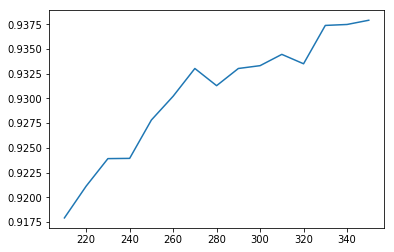

In [12]:
#如何确定合适的k
%matplotlib inline
import matplotlib.pyplot as plt
score = []
for i in range(350,200,-10):
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X_fsvar, y)
    once = cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()
    score.append(once)
plt.plot(range(350,200,-10),score)
plt.show()

#### 运用P值检测
卡方检验的本质是推测两组数据之间的差异，其检验的原假设是”两组数据是相互独立的”。卡方检验返回卡方值和P值两个统计量，其中卡方值很难界定有效的范围，而p值，一般使用0.01或0.05作为显著性水平，即p值判断的边界  

P|小于阈值|大于阈值
--|:--:|--:
数据差异|差异不是自然形成|差异是自然的样本误差
相关性|两组数据相关|两组数据相互独立
原假设|拒绝原假设，接受备择假设|接受原假设

In [13]:
chivalue, pvalues_chi = chi2(X_fsvar,y)
pvalues_chi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
chivalue.shape[0]

392

In [17]:
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
k

392

In [18]:
X_fschi = SelectKBest(chi2, k=k).fit_transform(X_fsvar, y)
cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9388098166696807

### F检验
F检验，又称ANOVA，方差齐性检验，是用来捕捉每个特征与标签之间的线性关系的过滤方法。它即可以做回归也可以做分类，因此包含feature_selection.f_classif(F检验分类)和feature_selection.f_regression(F检验回归)两个类。其中F检验分类用于标签是离散型变量的数据，而F检验回归用于标签是连续型变量的数据。

F检验在数据服从正态分布时效果会非常稳定，因此如果使用F检验过滤，需要先将数据转换成服从正态分布的方式。

F检验的本质是寻找两组数据之间的线性关系，其原假设是”数据不存在显著的线性关系“。它返回F值和p值两个统计量。

思考： why正态分布

In [19]:
from sklearn.feature_selection import f_classif
F,pvalues_f = f_classif(X_fsvar,y)
F

array([ 618.65383492,  846.18897012, 1115.40617051, 1362.3677305 ,
       1452.03355369, 1381.09095571, 1138.26505266,  464.29616121,
        660.00977785,  849.66393412, 1004.7450309 , 1124.76177588,
       1200.99190762, 1209.29489877, 1110.4944286 ,  854.66183292,
        577.52063451,  342.09729054,  178.67397866,  118.01145533,
        612.12261014,  899.40904291, 1196.17528948, 1424.49864852,
       1569.26556677, 1742.49910702, 1910.98023795, 1969.20520223,
       1731.37475948, 1295.09668012,  839.15325001,  531.97951763,
        371.82392681,  336.00820537,  378.93378743,  317.47025479,
        528.94881012,  766.40792176,  947.63168717, 1086.0472161 ,
       1177.72017709, 1253.79641973, 1344.06961068, 1507.33781169,
       1616.50454434, 1512.25864876, 1289.65180587, 1051.26276412,
        839.48869386,  680.07426932,  600.85538567,  633.55772663,
        683.96908509,  347.65867784,  452.76238211,  509.16387684,
        515.7498157 ,  532.86107778,  594.62512658,  664.18740

In [20]:
pvalues_f

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.71193533e-220,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [36]:
k = F.shape[0] - (pvalues_f > 0.05).sum()
k

392

In [38]:
X_fsF = SelectKBest(f_classif, k=k).fit_transform(X_fsvar, y)
cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fsF,y,cv=5).mean()

0.9388098166696807

### 互信息法
互信息法是用来捕捉每个特征与标签之间的任意关系(包括线性和非线性关系)的过滤方法。和F检验相似，它既可以做回归也可以做分类，并且包含两个类feature_selection.mutual_info_classif(互信息分类)和 feature_selection.mutual_info_regression(互信息回归)。这两个类的用法和参数都和F检验一模一样，不过 互信息法比F检验更加强大，F检验只能够找出线性关系，而互信息法可以找出任意关系。

互信息法不返回p值或F值类似的统计量，它返回“每个特征与目标之间的互信息量的估计”，这个估计量在[0,1]之间 取值，为0则表示两个变量独立，为1则表示两个变量完全相关。

In [21]:
from sklearn.feature_selection import mutual_info_classif as MIC
result = MIC(X_fsvar,y)
result

array([0.06993631, 0.08330239, 0.10259283, 0.1152163 , 0.11718048,
       0.10566585, 0.08147838, 0.05144574, 0.07419917, 0.10241877,
       0.12110731, 0.13760926, 0.16079681, 0.16586878, 0.14513028,
       0.12686926, 0.09553066, 0.05819486, 0.04211889, 0.02063632,
       0.0682048 , 0.09364586, 0.12273829, 0.15674711, 0.17679987,
       0.20676681, 0.22453458, 0.23732893, 0.21765135, 0.17817215,
       0.14194711, 0.10342029, 0.06859084, 0.0560314 , 0.04624681,
       0.03310984, 0.05280198, 0.07899737, 0.10309685, 0.11922619,
       0.13670738, 0.15157465, 0.16513443, 0.18132124, 0.18819832,
       0.17392391, 0.15433643, 0.13706864, 0.10541003, 0.09469067,
       0.08366965, 0.06726403, 0.06700389, 0.04645883, 0.06470149,
       0.07571494, 0.08888498, 0.10006336, 0.10434652, 0.10523933,
       0.10873541, 0.11641621, 0.12639178, 0.11905236, 0.11122131,
       0.11636676, 0.11160015, 0.10965565, 0.08798357, 0.08489494,
       0.07058252, 0.03614557, 0.05042659, 0.0683539 , 0.07314

In [22]:
k = result.shape[0] - sum(result <= 0)
k

392

In [23]:
X_fsmic = SelectKBest(MIC, k=k).fit_transform(X_fsvar, y)
cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fsmic,y,cv=5).mean()

0.9388098166696807

### 嵌入法
嵌入法是一种让算法自己决定使用哪些特征的方法，即特征选择和算法训练同时进行。在使用嵌入法时，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据权值系数从大到小选择特征。这些权值系 数往往代表了特征对于模型的某种贡献或某种重要性，比如决策树和树的集成模型中的feature_importances_属性，可以列出各个特征对树的建立的贡献，我们就可以基于这种贡献的评估，找出对模型建立最有用的特征。因此相比于过滤法，嵌入法的结果会更加精确到模型的效用本身，对于提高模型效力有更好的效果。并且，由于考虑特征对模型的贡献，因此无关的特征(需要相关性过滤的特征)和无区分度的特征(需要方差过滤的特征)都会因为缺乏对模型的贡献而被删除。

#### 嵌入法的缺点
- 过滤法中使用的统计量可以使用统计知识和常识来查找范围(如p值应当低于显著性水平0.05)，而嵌入法中使用的权值系数却没有这样的范围可找——权值系数为0的特征对模型丝毫没有作用，但当大量特征都对模型有贡献且贡献不一时，就很难去界定一个有效的临界值。这种情况下，模型权值系数就是超参数，需要进行调参
- 嵌入法引入了算法来挑选特征，因此其计算速度也会和应用的算法有很大的关系。如果采用计算量很大，计算缓慢的算法，嵌入法本身也会非常耗时耗力。

#### sklearn中的嵌入法
feature_selection.SelectFromModel class sklearn.feature_selection.SelectFromModel (estimator, threshold=None, prefit=False, norm_order=1, max_features=None)

SelectFromModel是一个元变换器，可以与任何在拟合后具有coef_，feature_importances_属性或参数中可选惩罚项的评估器一起使用(比如随机森林和树模型就具有属性feature_importances_，逻辑回归就带有l1和l2惩罚项，线性支持向量机也支持l2惩罚项)。

对于有feature_importances_的模型来说，若重要性低于提供的阈值参数，则认为这些特征不重要并被移除。 feature_importances_的取值范围是[0,1]，如果设置阈值很小，比如0.001，就可以删除那些对标签预测完全没贡 献的特征。如果设置得很接近1，可能删除大量的有效特征

In [24]:
from sklearn.feature_selection import SelectFromModel
RFC_ = RandomForestClassifier(n_estimators =10,random_state=0)
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y)
X_embedded.shape

(42000, 47)

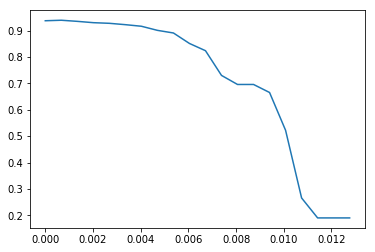

In [25]:
#利用学习曲线进行判断
threshold = np.linspace(0,(RFC_.fit(X,y).feature_importances_).max(),20)
score = []
for i in threshold:
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score.append(once)
plt.plot(threshold,score)
plt.show()

In [46]:
X_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
X_embedded.shape
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.939905083368037

### 包装法
包装法也是一个特征选择和算法训练同时进行的方法，与嵌入法十分相似，它也是依赖于算法自身的选择，比如 coef_属性或feature_importances_属性来完成特征选择。但不同的是，我们往往使用一个目标函数作为黑盒来帮 助我们选取特征，而不是自己输入某个评估指标或统计量的阈值。包装法在初始特征集上训练评估器，并且通过 coef_属性或通过feature_importances_属性获得每个特征的重要性。然后，从当前的一组特征中修剪最不重要的 特征。在修剪的集合上递归地重复该过程，直到最终到达所需数量的要选择的特征。区别于过滤法和嵌入法的一次 训练解决所有问题，包装法要使用特征子集进行多次训练，因此它所需要的计算成本是最高的。

最典型的目标函数是递归特征消除法(Recursive feature elimination, 简写为RFE)。它是一种贪婪的优化算法， 旨在找到性能最佳的特征子集。它反复创建模型，并在每次迭代时保留最佳特征或剔除最差特征，下一次迭代时，它会使用上一次建模中没有被选中的特征来构建下一个模型，直到所有特征都耗尽为止。 然后，它根据自己保留或 剔除特征的顺序来对特征进行排名，最终选出一个最佳子集。包装法的效果是所有特征选择方法中最利于提升模型表现的，它可以使用很少的特征达到很优秀的效果。除此之外，在特征数目相同时，包装法和嵌入法的效果能够匹敌，不过它比嵌入法算得更见缓慢，所以也不适用于太大型的数据。相比之下，包装法是最能保证模型效果的特征选择方法。

class sklearn.feature_selection.RFE (estimator, n_features_to_select=None, step=1, verbose=0)

参数estimator是需要填写的实例化后的评估器，n_features_to_select是想要选择的特征个数，step表示每次迭代中希望移除的特征个数。

除此之外，RFE类有两个很重要的属性，.support_:返回所有的特征的是否最后被选 中的布尔矩阵，以及.ranking_返回特征的按数次迭代中综合重要性的排名。

类feature_selection.RFECV会在交叉 验证循环中执行RFE以找到最佳数量的特征，增加参数cv，其他用法都和RFE一模一样。

In [48]:
from sklearn.feature_selection import RFE
RFC_ = RandomForestClassifier(n_estimators =10,random_state=0)
selector = RFE(RFC_, n_features_to_select=340, step=50).fit(X, y)

In [49]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,

In [50]:
selector.ranking_

array([10,  9,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  6,  6,
        5,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  5,  4,
        4,  5,  3,  4,  4,  4,  5,  4,  5,  7,  6,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  7,  4,  3,  1,  2,  3,  3,  1,  1,  1,  1,
        1,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9,  9,  9,  8,  9,  9,  4,
        4,  3,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  4,
        5,  5,  9,  9, 10, 10, 10, 10,  7,  4,  4,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  5,  8, 10, 10, 10,
       10,  9,  4,  4,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  4, 10, 10, 10, 10,  9,  7,  4,  3,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        4,  4, 10,  9, 10

In [51]:
X_wrapper = selector.transform(X)
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()

0.9389522459432109

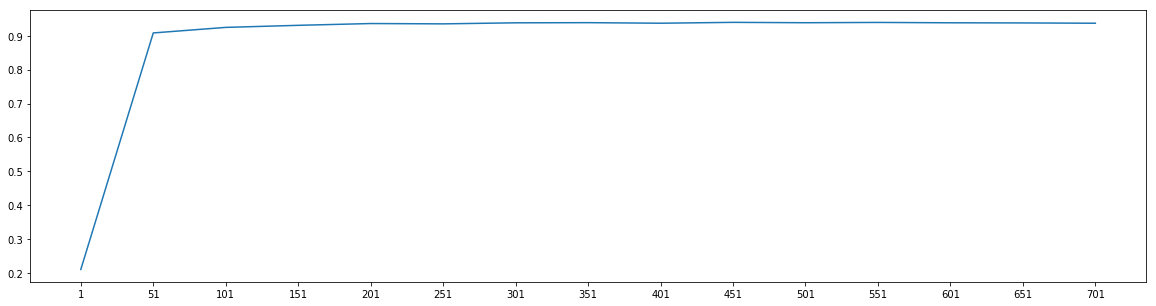

In [52]:
#包装法学习曲线
score = []
for i in range(1,751,50):
    X_wrapper = RFE(RFC_,n_features_to_select=i, step=50).fit_transform(X,y)
    once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,751,50),score)
plt.xticks(range(1,751,50))
plt.show()

### 特征选择总结
经验来说，过滤法最快，但更粗糙。包装法和嵌入法更精确，比较适合具体到算法去调整，但计算量比较大，运行时间长。当数据量特征维度很大的时候，优先使用方差过滤和互信息法调整，再上其他特征选择方法。

特征的组合可能会更加有效，称之为衍生特征。这是比调参和特征选择更难的，提升算法表现的高深方法。

### 额外的内容。。。
- OrdinalEncoder与LabelEncoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinalEncoder = OrdinalEncoder(categories=[
    ['1-7H','8-12H','13-18H','19-24H'],
    ['AA','BB','CC','DD','EE','FF','GG','HH','II'],
    ['M','F'],
    ['iOS','Android','iPhone OS'],
    ['元朗', '沙田', '观塘', '葵青', '屯门', '黄大仙', '北区', '西贡', '深水埗', '九龙城',
       '东区', '大埔', '油尖旺', '南区', '荃湾', '离岛', '中西区', '湾仔'],
    ['与父母同住', '租用', '公共房屋', '自置(无按揭)', '自置(有按揭)', '其他', '套房'],
                                 ])
df_.loc[:,['apply_hour','grade','gender','system','分区','房屋类别']] = ordinalEncoder.fit_transform(df_.loc[:,['apply_hour','grade','gender','system','分区','房屋类别']])
df_.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(df_['是否逾期'])
X = df_.drop(['是否逾期'],axis=1)